# 13:57, 23rd September


# XGBoost Hyperparameter Tuning

 ***The code below is run in Google Colab environment which provides us with GPU for fast calculation.***


## 01. Objective

The hyperparamter tuning is important not only for improving the performance of the objective function but also for operating 'regularization' to address "variance-bias trade-off", the risk of 'over-fitting'.  

The objective of this project is to conduct hyperparameter tuning to improve the overall performance of the Native XGBoost API in the context of regression prediction, using a sklearn's California Housing Dataset.

This project uses "k-fold cross validation" on the training dataset to tune a selected hyperparameters to search for the global minimum of the objective function. After the tuning, we will do a cross-check to compare between the training performances and the test performance of the tuned model. This process is important to assess "variance-bias trade-off".


## 02.  Open Source Native XGBoost API
    This analysis uses the native XGBoost API (not the sklearn API) 
    
    Here is the link to the open source native XGBoost API: https://github.com/dmlc/xgboost 
    
    Here is an excerpt from the XGBoost open source API:
    
> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Kubernetes, Hadoop, SGE, MPI, Dask) and can solve problems beyond billions of examples. (Source: https://github.com/dmlc/xgboost) 

### Advantage to use the Native XGBoost API 
    Apart from the native API, We also have the scikit-learn API of XGBoost. The scikit-learn AP is easy to use and fits well in a scikit-learn pipeline.
    Nevertheless, it is sometimes better to use the native version for the following advantages:
    
    * Automatically find the best number of boosting rounds 
    * Built-in cross validation 
    * Custom objective functions



In [1]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [2]:
# !pip uninstall xgboost


In [3]:
# pip install xgboost

Hyperparameter tuning can be computationally very expensive depending on how you set the search grid. Simply because it needs to iterate performance calculations over all the datapoints determined by the search-grid. The more datapoints you have, the more expensive computationally. Very simple. 

Unfortunately, my notebook has a very limited computational capacity. A good news is that Google Colab provides one GPU per user for a free account. And XGBoost has GPU support feature. Altogether, I can speed up the tuning process using Google Colab's GPU.

To check which GPU is allocated by Google Colab

```Python
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
```
Or 
```Python
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi -L
```
For a simple summary


In [4]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sun Sep 18 15:06:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |            

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-13d326dd-ad69-91a8-f680-45bb482dccd3)


Tesla T4 is allocated to GPU ID =0.


In [6]:
!pip install -U xgboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [7]:
import xgboost as xgb # call native XGBoost API # For Google Colab we have a dofferent approach
from sklearn.model_selection import train_test_split # to split the dataset into the train and the test datasets
from sklearn.metrics import mean_squared_error # 
import pandas as pd 
import time # to measure the performance time for some executions such as training and cross validation

## 03. Data Preparation

Repeatedly, XGBoost embeds in its architecture a method called "default direction" to handle sparse-data structures and missing data. 

For this reason, it is not necessary to impute the missing values during the data preparation stage.

### a) California Housing Data
We can download California Housing Dataset from ***sklearn.datasets*** using ***fetch_california_housing*** function. 
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

In [8]:
from sklearn.datasets import fetch_california_housing
housing_data = fetch_california_housing()

In [9]:
type(housing_data)

sklearn.utils.Bunch

In [10]:
descr = housing_data['DESCR']
feature_names = housing_data['feature_names']
data = housing_data['data']
target = housing_data['target']
df1 = pd.DataFrame(data=data)
df1.rename(columns={0: feature_names[0], 1: feature_names[1], 2: feature_names[2], 3: feature_names[3],
 4: feature_names[4], 5: feature_names[5], 6: feature_names[6], 7: feature_names[7]}, inplace=True)
df2 = pd.DataFrame(data=target)
df2.rename(columns={0: 'Target'}, inplace=True)
housing = pd.concat([df1, df2], axis=1)
print(housing.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Target'],
      dtype='object')


In [11]:
print("dimension of housing data: {}".format(df1.shape))

dimension of housing data: (20640, 8)


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


### b) Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing.loc[:, housing.columns != 'Target'], housing['Target'], random_state=66)

In [14]:
X=housing.loc[:, housing.columns != 'Target']
y=housing['Target']

In [15]:
type(housing)

pandas.core.frame.DataFrame

### c) <font color=blue>  Conversion to DMatrices for XGBoost:</font>

Instead of numpy arrays or pandas dataFrame, XGBoost uses DMatrices. So, we have to convert our dataset into DMatrix.

A DMatrix can contain both the features and the target.



> DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data. \
(Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix)



#### <font color=blue> Load data into DMatrix </font>
   Now we convert the numpy arrays of X and y into a DMatrix:


In [16]:
dmatrix = xgb.DMatrix(data=X, label=y)

In [17]:
DM_train = xgb.DMatrix(X_train, label=y_train)
DM_test = xgb.DMatrix(X_test, label=y_test)

## 05. Methodology

Our objective is to perform hyperparamter tuning of XGBoost model to improve its performance while addressing ***variance-bias trade-off*** to alleviate the risk of overfitting.

For this purpose, we use ***k-fold Cross Validation*** to tune the selected hyperparameters. 

***k-fold Cross Validation*** can be iterated over different values of the hyperparameters to search ***the global minimum*** of the regression performance. 



### a) What is k-fold Cross Validation?
Here is a brief summary of k-fold Cross Validation from Wikipedia. source: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation

> In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used,[16] but in general k remains an unfixed parameter.

Needless to say, the cross validation process only use ***the train dataset***. We do not pass ***the test-dataset*** into the cross validation function: `xgb.cv()`.


#### A Tip for Cross-Validation


Here is a recommendation regarding ***Cross Validation*** by Horace at Stackexchange: \
https://stats.stackexchange.com/questions/436894/should-a-training-set-be-used-for-grid-search-with-cross-validation

> It is recommended to hold out a test set that the model only sees at the end, but not during the parameter tuning and model selection steps.
Grid search with cross-validation is especially useful to performs these steps, this is why the author only uses the train data.

> If you use your whole data for this step, you will have picked a model and a parameter set that work best for the whole data, including the test set. Hence, this is prone to overfitting.

> Usually it is recommended to either:

> - Split your dataset into three folds: <font color=blue>train </font>, <font color=green>validation </font>, and <font color=red> test </font>. Then, perform the model selection and hyperparameter search, each time training on <font color=blue>the train set</font>, and checking the score on <font color=green>the validation set</font>.
> - Split into two folds: <font color=blue>train </font> and <font color=red> test </font>, and then perform cross-validations on <font color=blue>the train set</font> to do the model selection and hyperparameter search. 






### b) Fosus for Tuning: Selection of Hyperparameters
There are so many hyperparameters used for XGBoost: https://xgboost.readthedocs.io/en/latest/parameter.html.

Among many hyperparameters built in the native XGBoost API, this analysis focuses on the following 9 hyperparameters under the given limited computational resource availablity. 



#### 1. One Hyperparameter for Iteration Control:

Both the native training function and the native cross-validation function, respectively **xgb.train()** and **xgb.cv()**, enable the users to control the maximum number of iterations, num_boost_round, using 'early_stopping_round'. These 2 hyperparameters work together to control the iteration of the optimization process.


- ***`num_boost_round`*** (int) sets the maximum number of boosting rounds/iterations for the optimization operation. And it can be tuned by using ***`early_stopping_round`***. Here is its definition in the Native Learning API'sdocument:
> num_boost_round (int) – Number of boosting iterations. (Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv()#xgboost.train)

- ***`early_stopping_round`*** monitors the improvement of the selected evaluation metrics (e.g. `mae`) at each iteration and stops the optimization process when further iterations no longer improve the metrics. Here is its definition in the Native Learning API's document:
>early_stopping_rounds (Optional[int]) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in evals. The method returns the model from the last iteration (not the best one). Use custom callback or model slicing if the best model is desired. If there’s more than one item in evals, the last entry will be used for early stopping. If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping. If early stopping occurs, the model will have two additional fields: `bst.best_score`, `bst.best_iteration`. (Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv()#xgboost.train)


Footnote:

***`num_boost_round`*** is a hyperparameter that is set in the native XGBoost API. Its equivalence of Sklearn API is ***`n_estimators`*** according to the definition of ***`n_estimators`*** in Sklearn API doc:
> n_estimators: int, default=100
> The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. Values must be in the range [1, inf).

(Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
    
The remaining 8 hyperparameters (6 for Tree Boosting and 2 for Regularization) are going to be stored in ***the parameter dictionary*** as described in the section c) below.
    
#### 2. Shrinkage:
First, we can control the learning rate with `eta` to penalyze the learning process.

> - <font color=blue> ***eta***</font>  [default=0.3, alias: learning_rate] (range: [0,1]): Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

#### 3. Hyperparameters to Trees Constraints:
Now, this analysis further selected 3 hyperparameters below to constrain trees.

(Source: https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)


> - <font color=blue> ***max_depth*** </font> [default=6] (range: [0,∞]): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value. 
> - <font color=blue> ***min_child_weight*** </font> [default=1] (range: [0,∞]): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
> - <font color=blue> ***gamma*** </font> [default=0, alias: min_split_loss] (range: [0,∞]): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. 



#### 4. Random Sampling

> - <font color=blue> ***subsample*** </font> [default=1] (range: (0,1]): Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. 
> - <font color=blue> ***colsample_bytree*** </font> [default=1] (range of (0, 1]): All colsample_by* parameters is a family of parameters for subsampling of columns and specifies the fraction of columns to be subsampled. colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

#### 5. Regularization of the Objective Function:
    
In order to further address ***variance-bias trade-off***, the problem of ***overfitting***, we can tune ***L1 and L2 regularization hyperparameters***: `reg_alpha` and `reg_lambda`. 

> <font color=blue> ***alpha*** </font> [default=0, alias: <font color=blue> ***reg_alpha***</font>]: L1 regularization term on weights. Increasing this value will make model more conservative.

> <font color=blue> ***lambda*** </font> [default=1, alias: <font color=blue> ***reg_lambda***</font>]: L2 regularization term on weights. Increasing this value will make model more conservative.


    

### c) Parameter Dictionary
Both `xgb.train()` function and `xgb.cv()` function of the Native API requires major hyperparameters to be stored in the form of dictionary. Call it ***the parameter dictionary***. For the hyperprameter tuning, we can use the parameter dictionary to manipulate hyperparameters' values during the k-fold cross-validation.

Among our selection of hyperparameters, the 8 hyperparameters except ***`num_boost_round`*** and  ***`early_stopping_round`*** need to be stored in ***the parameter dictionary***. 

In addition, we need to specify 4 other hyperparameters in ***the parameter dictionary***:
- `objective`: the objective function
- `eval_metric`: the evaluation metrics 
- `gpu_id`: 0 as specified earlier by Google Colab 
- `tree_method`: `gpu_hist` to select GPU setting

Importantly, these four hyperparameters are fixed and not to be tuned during the tuning. 

For the first two hyperparameters, since our objective is 'regression' prediction, we need to select appropriate objective function and evaluation metric 'regression' analysis.

'gpu_id' is required to make GPU's ID specifications in order to use the GPU facility provided by Google Colab.

The last component `tree_method` is set to `gpu_hist` in order to exploit XGBoost's built-in GPU support.


After all, here is the initialization of our parameter dictionary. The values assigned here are solely for the initialization purpose. These values (except for 'objective' and 'eval_metric') will change during the hyperparameter tuning.
```Python
{'objective': 'reg:squarederror', # fixed and not tuned. pick an objective function for Regression. 
 'max_depth': 6,
 'subsample': 1,
 'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': 'mae', # fixed and not tuned. pick a evaluation metric for Regression.
 'gpu_id': 0, 
 'tree_method': 'gpu_hist' # GPU setting
}

```


In [18]:
param_dict={'objective': 'reg:squarederror', # fixed. pick an objective function for Regression. 
 'max_depth': 6,
 'subsample': 1,
 'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': 'mae', # fixed. picked a evaluation metric for Regression.
 'gpu_id': 0, 
 'tree_method': 'gpu_hist' # XGBoost's built-in GPU support to use Google Colab's GPU
}

In [19]:
param_dict

{'objective': 'reg:squarederror',
 'max_depth': 6,
 'subsample': 1,
 'eta': 0.3,
 'min_child_weight': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': 'mae',
 'gpu_id': 0,
 'tree_method': 'gpu_hist'}

Besides those hyperparameters specified in ***pram_dict***, we need to initialize 2 other hyperparamters `num_boost_round` and `early_stopping_rounds` outside of ***pram_dict***.

In [20]:
num_boost_round = 1000
early_stopping_rounds=10

### d) Pre-Tuning Regression

Use the built-in `train()` function to calculate the evaluation metric, MAE, of the test dataset. \
Here is the doc regarding the hyperparameters of `.train()`: \
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=train()#xgboost.train
- evals: a list of pairs (test_dmatrix, name_of_test). Here we will use our datasets in the form of DMatrix.
> *List of validation sets for which metrics will evaluated during training. Validation metrics will help us track the performance of the model.* (Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=train()#xgboost.train)

- early_stopping_rounds: As aforementioned, it is the number of rounds without improvements after which we should stop, here we set it to 10.

- evals_result: 
> *This dictionary stores the evaluation results of all the items in watchlist.*  
> *Example: with a watchlist containing [(dtest,'eval'), (dtrain,'train')] and a parameter containing ('eval_metric': 'logloss'), the evals_result returns:
> {'train': {'logloss': ['0.48253', '0.35953']},
> 'eval': {'logloss': ['0.480385', '0.357756']}}*

Source: https://stackoverflow.com/questions/58495721/how-do-i-use-model-evals-result-in-xgboost-if-i-am-using-gridsearchcv
> In general you can access the dictionary evals_result directly, as opposed to accessing a method of the model, e.g. xgb_model.evals_result(). Here is another, more detailed reference: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/evals_result.py 



In [21]:
def bias_variance_performance(params):
    cpu_starting_time = time.process_time() # record the starting time of CPU time
    wt_starting_time =time.time() # record the starting time of the Wall Time 
    
    evals_result = {}
    model = xgb.train(
        params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        evals=[(DM_train, "Train"), (DM_test, "Test")],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    train_error = evals_result["Train"]["mae"]
    test_error = evals_result["Test"]["mae"]
    
    wt_performance_time = time.time() - wt_starting_time # measure the Wall-time base performance time of this particular execution.
    cpu_performance_time = time.process_time() - cpu_starting_time # measure the CPU-time base performance time of this particular execution.
    print("Best MAE before the Tuning: {:.4f} with {} rounds".format(model.best_score, model.best_iteration+1))
    print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
    print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))

    return model, evals_result


In [22]:
pre_model, pre_evals_result=bias_variance_performance(params=param_dict)

[0]	Train-mae:1.11095	Test-mae:1.13306
[1]	Train-mae:0.81848	Test-mae:0.84093
[2]	Train-mae:0.63216	Test-mae:0.65401
[3]	Train-mae:0.51177	Test-mae:0.53601
[4]	Train-mae:0.44610	Test-mae:0.47297
[5]	Train-mae:0.40109	Test-mae:0.42935
[6]	Train-mae:0.37672	Test-mae:0.40723
[7]	Train-mae:0.36261	Test-mae:0.39459
[8]	Train-mae:0.35050	Test-mae:0.38401
[9]	Train-mae:0.33694	Test-mae:0.37105
[10]	Train-mae:0.32761	Test-mae:0.36234
[11]	Train-mae:0.32428	Test-mae:0.36075
[12]	Train-mae:0.32064	Test-mae:0.35846
[13]	Train-mae:0.31765	Test-mae:0.35747
[14]	Train-mae:0.31329	Test-mae:0.35480
[15]	Train-mae:0.30771	Test-mae:0.35056
[16]	Train-mae:0.30215	Test-mae:0.34693
[17]	Train-mae:0.29919	Test-mae:0.34541
[18]	Train-mae:0.29337	Test-mae:0.34118
[19]	Train-mae:0.29006	Test-mae:0.33994
[20]	Train-mae:0.28749	Test-mae:0.33895
[21]	Train-mae:0.28522	Test-mae:0.33792
[22]	Train-mae:0.28307	Test-mae:0.33696
[23]	Train-mae:0.28101	Test-mae:0.33563
[24]	Train-mae:0.27887	Test-mae:0.33541
[25]	Train

In [23]:
pre_model

In [24]:
pre_best_performance = pre_model.best_score


#### Utility Function: Visualizing Train Test Performance History
The next cell defines a visualization utility function to plot the performance curve along the iterations.

In [25]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
def epoch_MAE_visual(evals_result, title):
    graph_title = str(title) + "_XGBoost_MAE"
    train_error = evals_result["Train"]["mae"]
    test_error = evals_result["Test"]["mae"]
    fig = plt.style.use("ggplot")

    epochs = len(evals_result["Train"]["mae"])
    x_axis = range(0, epochs)
    fig, ax = pyplot.subplots(figsize=(12,12))
    ax.plot(x_axis, evals_result["Test"]["mae"], label="Test")
    ax.plot(x_axis, evals_result["Train"]["mae"], label="Train")
    ax.legend()

    pyplot.xlabel("epochs")
    pyplot.ylabel("mae")
    pyplot.title(graph_title)
    pyplot.show()

# Download the figure as jpeg file.
    
    file_name = graph_title + ".jpg" 
    return fig.savefig(graph_title), graph_title


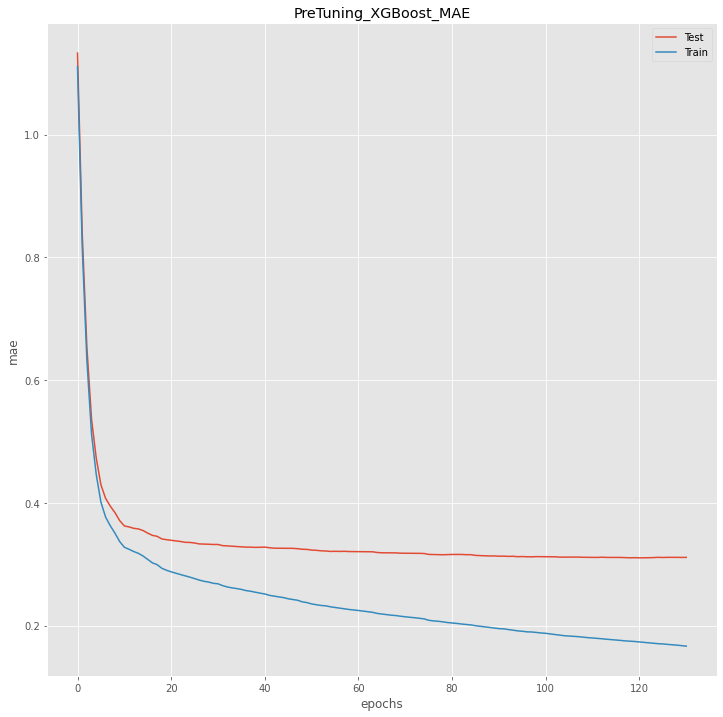

(None, 'PreTuning_XGBoost_MAE')

In [26]:
epoch_MAE_visual(evals_result=pre_evals_result, title="PreTuning")

### e) Hyperparameter Tuning via k-fold cross-validation: ***cv*** function. 


To tune hyperparameters, we can iterate ***k-fold Cross Validation*** to calculate the performance metrics over all the hyperparameter datapoints on the search-grid: to search ***the global minimum*** of the performance landscape. 


#### Parameters for the Cross Validation function: 
Documentation source: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cross%20validation#xgboost.cv


The design of the native cross validation function specifies explicitly a few hyperparameters: such as ***num_boost_round***, ***early_stopping_rounds***, ***nfold***, ***seed***, and ***metrics***. Nevertheless, other hyperparameters, e.g. those constraining trees and those for random sampling, are implicitly included into ***params*** in the dictionary form.    

Importantly, for the cross validation process, we use only "Train Dataset".

- <font color=blue> ***params*** </font>: the hyperparameter dictionary to be defined in the next section. This dictionary sets the scope of the model's hyperparameters tuning.
- <font color=blue> ***dtrain*** </font>: Train Dataset in DMatrix form
- <font color=blue> ***num_boost_round*** </font> (int) – Number of boosting iterations.
- <font color=blue> ***nfold*** </font> (int) – Number of folds in CV.
- <font color=blue> ***metrics*** </font> (string or list of strings) – Evaluation metrics to be watched in CV.
- <font color=blue> ***early_stopping_rounds*** </font> (int) – Activates early stopping. Cross-Validation metric (average of validation metric computed over CV folds) needs to improve at least once in every early_stopping_rounds round(s) to continue training. The last entry in the evaluation history will represent the best iteration. If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping.
- <font color=blue> ***seed*** </font> (int) – Seed used to generate the folds (passed to numpy.random.seed).



Here is the python code.

```python
cv_results = xgb.cv(
        params=param_dict,
        dtrain=DM_train, #only use "Train Dataset" in DMatrix form.
        num_boost_round=num_boost_round,
        seed=42, # seed for randomization
        nfold=5, # k of k-fold cross-validation:an important parameter that determines the ratio of validation dataset
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds   
    )
```




Now, we can customize the cross validation function for the ease of ***pair-wise hyperparameter tuning***. This part is optional based on personal preference. 

The following utility function will calculate the performance metrics for the given set of hyperparamters values.


In [27]:

def cross_validation(param_dict, DM_train, metrics, num_boost_round, early_stopping_rounds): 
# Exlpanation of parameters passed to the function
# 1) The hyperparamters of the model specification
## params_dict: the parameter dictionary of the model created earlier

# 2) Hyperparameters for iteration control in xgb.train() and xgb.cv()
## num_boost_round: num_boost_round (int) – Number of boosting iterations.
## early_stopping_rounds:Activates early stopping. 
##                       Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. 
# 3) Parameters for the Cross Validation process
## metrics: `mae`
## seed: seed for randomization
## nfold: k of k-fold cross validation
    
    cv_results = xgb.cv(
        params=param_dict,
        dtrain=DM_train, #only use "Train Dataset" in DMatrix. 
        num_boost_round=num_boost_round,
        seed=42, # seed for randomization
        nfold=5, # k of k-fold cross-validation:an important parameter that determines the ratio of validation dataset
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds   
    )
    
    return cv_results

Now, we can define the grid-search process using the pair-wise parameter tuning.

This function, ***pair_wise_gridsearch_CV***, takes three parameters: the names of the pair of hyperparameters to be tuned, ***param1_name*** and ***param2_name***, and the search-grid of the hyperparameter pair, ***gridsearch_params***.

The function iterates the custom cross-validation function, ***cross_validation***, over all the datapoints on the search-grid of the hyperparameter pair defined in ***gridsearch_params*** to search for the global minimum of the performance landscape.


In [28]:
## Generalization of Pair-wise Gridsearch


def pair_wise_gridsearch_CV(param1_name, param2_name, gridsearch_params):
    
    cpu_starting_time = time.process_time() # record the starting time of CPU time
    wt_starting_time =time.time() # record the starting time of the Wall Time 

    min_mae = float("Inf")
    best_params = None

    x = []
    y = []
    z = []
    for param1, param2 in gridsearch_params:
        # Update our parameter dictionary for the tuning
        param_dict[param1_name] = param1
        param_dict[param2_name] = param2
        print("CV with {}={}, {}={}".format(param1_name, param1,
                             param2_name,
                             param2))
        # calculate cross_validation
        cv_results = cross_validation(param_dict, DM_train, metrics={'mae'}, num_boost_round=1000, early_stopping_rounds=10)
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        
        x.append(param1)
        y.append(param2)
        z.append(mean_mae)
        
        print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
        
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (param1, param2)
     
    wt_performance_time = time.time() - wt_starting_time # measure the Wall-time base performance time of this particular execution.
    cpu_performance_time = time.process_time() - cpu_starting_time # measure the CPU-time base performance time of this particular execution.

    return x, y, z, min_mae, best_params, cpu_performance_time, wt_performance_time
        

### f) Performance Landscape: 3D Visualization of Pair-Wise Hyperparameter Tuning: Tri-Surface Plot with Color Map
- Source1: https://matplotlib.org/3.1.0/tutorials/toolkits/mplot3d.html#sphx-glr-tutorials-toolkits-mplot3d-py
- Source2 Geek4Geeks (Color Map): https://www.geeksforgeeks.org/tri-surface-plot-in-python-using-matplotlib/

We can define a visualization utility function 'Tri-Surface', by using matplotlib’s 'plot_trisurf' to render 3D Visualization of the performance landscape of the hyperparameters. 

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Trisurf(xname, yname, x, y, z, min_mae, best_params):
    # (xname, yname): the name of variables to be displayed for visualization
    # (`x`,`y`): all the hyperparamters' datapoints on the search grid 
    # (`z`): the results of the evaluation metric the results of the evaluation metric over the datapoints
    # (`min_mae`, `best_params`): the Native XGBoost API's `k-fold cross-validation` function's outputs the minimum mae result and the corresponding datapoint of the hyperparameters
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection="3d")
    # Creating color map
    my_cmap = plt.get_cmap('RdPu')
    
    # Creating dot plot of the minimum
    ## min_mae*1.01 to float it for the visualization purpose.
    ax.scatter(best_params[0], best_params[1], min_mae, color='red')
    # Tri-Surface Plot
    ax.plot_trisurf(x,y,z,cmap = my_cmap,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel('mae')
    
    # Write the Title
    ax.set_title("Hyperparameters Performance Landscape ("+str(xname) + ' & '+str(yname)+")") 
    
    # Download the figure as jpeg file.
    figname = str(xname) + '_'+str(yname)
    fig.savefig(str(figname) + '.jpg')
    


## 06 The 1st Round of Tuning Implementation

Now, it's time for the implementation of hyperparameter tuning.

We will perform a ***pair-wise hyperparameter tuning*** for each pair at a time using the built-in ***k-fold cross validation*** of the Native XGBoost API. After every pair-wise tuning, we will update the hyperparameter values for each pair with the best result (which yields the lowest value of the valuation metric). In this way, we can incrementally improve the performance of the tuned model. And we move on to the next pair of hyperparameters to repeat the process. 

We will go over this process now. 

### a) The 1st pair: `max_depth` & `eta`

First, we tune the following two hyperparameters together.
> - <font color=blue> ***max_depth*** </font> [default=6] (range: [0,∞]): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value. 
> - <font color=blue> ***eta***</font>  [default=0.3, alias: learning_rate] (range: [0,1]): Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.


In [30]:
pair_wise_gridsearch_params1 = [
    (max_depth, eta)
    for max_depth in range(5,15)
    for eta in [i/10. for i in range(1, 10)]
]


In [31]:
 x1, y1, z1, min_mae1, best_params1, cpu_performance_time, wt_performance_time= pair_wise_gridsearch_CV('max_depth', 'eta', pair_wise_gridsearch_params1)

CV with max_depth=5, eta=0.1
	MAE 0.30003206578759567 for 517 rounds
CV with max_depth=5, eta=0.2
	MAE 0.30515106945113313 for 233 rounds
CV with max_depth=5, eta=0.3
	MAE 0.3128562059599993 for 158 rounds
CV with max_depth=5, eta=0.4
	MAE 0.31994136049092126 for 114 rounds
CV with max_depth=5, eta=0.5
	MAE 0.3288253008895758 for 72 rounds
CV with max_depth=5, eta=0.6
	MAE 0.33645839759699747 for 77 rounds
CV with max_depth=5, eta=0.7
	MAE 0.34661519343096003 for 53 rounds
CV with max_depth=5, eta=0.8
	MAE 0.35609125627122956 for 34 rounds
CV with max_depth=5, eta=0.9
	MAE 0.36023939917542674 for 28 rounds
CV with max_depth=6, eta=0.1
	MAE 0.30012685565677416 for 491 rounds
CV with max_depth=6, eta=0.2
	MAE 0.30631245030066145 for 216 rounds
CV with max_depth=6, eta=0.3
	MAE 0.3154876568819124 for 130 rounds
CV with max_depth=6, eta=0.4
	MAE 0.3234618299585365 for 79 rounds
CV with max_depth=6, eta=0.5
	MAE 0.3355685753184695 for 52 rounds
CV with max_depth=6, eta=0.6
	MAE 0.3488779200

In [32]:
print("Best params: {}, {}, MAE: {}".format(best_params1[0], best_params1[1], min_mae1))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 7, 0.1, MAE: 0.2988302932498683
Wall-time base performance time: 745.1331 seconds
CPU base performance time: 746.2117 seconds


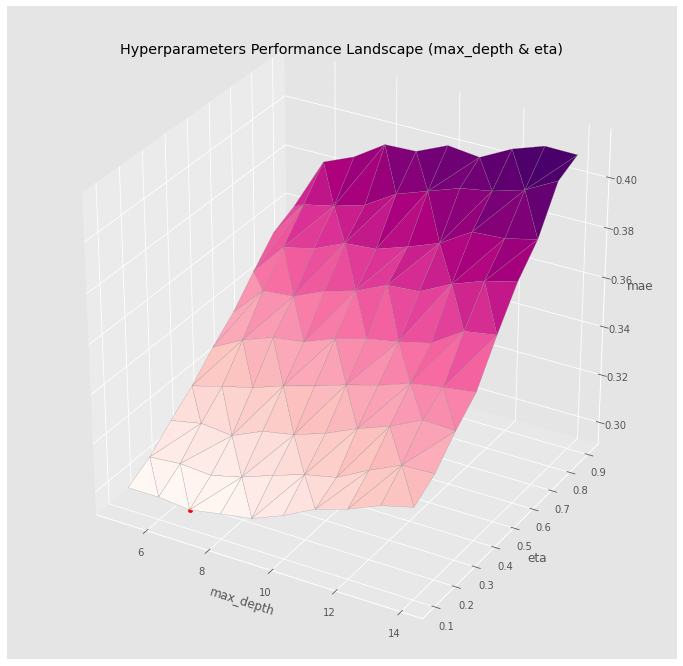

In [33]:
Trisurf("max_depth", 'eta',x1,y1,z1, min_mae1, best_params1)

In [34]:
param_dict["max_depth"] = best_params1[0]
param_dict["eta"]= best_params1[1]

The performance landscape of the first pair, `max_depth` and `eta`, did not demonstrated  multiple dips and bumps. The relative consistency in the shape of the performance landscape appears to indicate a model stability.

### b) The 2nd pair: `subsample` and `colsample_bytree`

Second, we have two hyperparameters associated with random subsampling, `subsample` and `colsample_bytree`. 

Since both deal with random subsampling, they might demonstrate some interactions between each other.
For this reason, we conduct a pair-wise tuning over the two hyperparameters together. 


> - <font color=blue> ***subsample*** </font> [default=1] (range: (0,1]): Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. 

> - <font color=blue> ***colsample_bytree*** </font> [default=1] (range of (0, 1]): All colsample_by* parameters is a family of parameters for subsampling of columns and specifies the fraction of columns to be subsampled. colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.


In [35]:
pair_wise_gridsearch_params2 = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(1, 10)]
    for colsample_bytree in [i/10. for i in range(1, 10)]
]
# print(gridsearch_params)

In [36]:
 x2, y2, z2, min_mae2, best_params2 ,cpu_performance_time, wt_performance_time= pair_wise_gridsearch_CV('subsample', 'colsample_bytree', pair_wise_gridsearch_params2)

CV with subsample=0.1, colsample_bytree=0.1
	MAE 0.45368746592728204 for 245 rounds
CV with subsample=0.1, colsample_bytree=0.2
	MAE 0.45368746592728204 for 245 rounds
CV with subsample=0.1, colsample_bytree=0.3
	MAE 0.3887355276799787 for 153 rounds
CV with subsample=0.1, colsample_bytree=0.4
	MAE 0.36028195662900464 for 113 rounds
CV with subsample=0.1, colsample_bytree=0.5
	MAE 0.34667969396053894 for 143 rounds
CV with subsample=0.1, colsample_bytree=0.6
	MAE 0.34667969396053894 for 143 rounds
CV with subsample=0.1, colsample_bytree=0.7
	MAE 0.34958488635853585 for 92 rounds
CV with subsample=0.1, colsample_bytree=0.8
	MAE 0.3582255050231936 for 54 rounds
CV with subsample=0.1, colsample_bytree=0.9
	MAE 0.35052855665138527 for 136 rounds
CV with subsample=0.2, colsample_bytree=0.1
	MAE 0.43811195975973316 for 320 rounds
CV with subsample=0.2, colsample_bytree=0.2
	MAE 0.43811195975973316 for 320 rounds
CV with subsample=0.2, colsample_bytree=0.3
	MAE 0.36811884161595076 for 174 rou

In [37]:
print("Best params: {}, {}, MAE: {}".format(best_params2[0], best_params2[1], min_mae2))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 0.9, 0.8, MAE: 0.2960672089507568
Wall-time base performance time: 426.5385 seconds
CPU base performance time: 429.4474 seconds


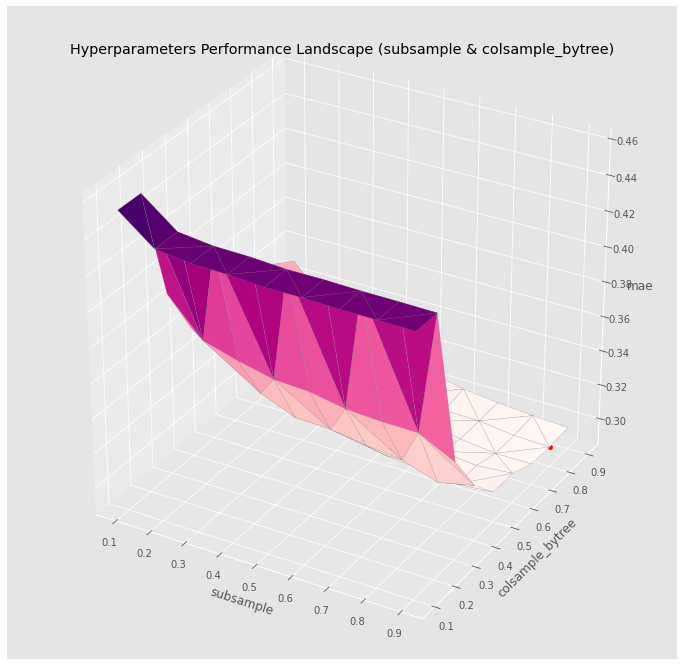

In [38]:
Trisurf('subsample','colsample_bytree', x2,y2,z2, min_mae2, best_params2)

In [39]:
param_dict["subsample"] = best_params2[0]
param_dict["colsample_bytree"]= best_params2[1]

The second performance landscape of these two subsampling hyperparameters,`subsample` & `colsample_bytree`, did not demonstrated multiple dips and bumps. The relative consistency of in the shape of the performance landscape appears to indicate a model stability.

### c) The 3rd pair: `min_child_weight` & `gamma`

Third, we tune together the following two hyperparameters associated with partitoin of trees.
> - <font color=blue> ***min_child_weight*** </font> [default=1] (range: [0,∞]): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
> - <font color=blue> ***gamma*** </font> [default=0, alias: min_split_loss] (range: [0,∞]): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. 


In [40]:
pair_wise_gridsearch_params3 = [
    (min_child_weight, gamma)
    for min_child_weight in range(0, 10)
    for gamma in range(0, 10)
]
# print(gridsearch_params)

In [41]:
 x3, y3, z3, min_mae3, best_params3, cpu_performance_time, wt_performance_time = pair_wise_gridsearch_CV('min_child_weight', 'gamma', pair_wise_gridsearch_params3)

CV with min_child_weight=0, gamma=0
	MAE 0.2960672089507568 for 259 rounds
CV with min_child_weight=0, gamma=1
	MAE 0.31695686558150815 for 127 rounds
CV with min_child_weight=0, gamma=2
	MAE 0.32817960719768086 for 54 rounds
CV with min_child_weight=0, gamma=3
	MAE 0.3331657405894548 for 46 rounds
CV with min_child_weight=0, gamma=4
	MAE 0.33714212804493665 for 41 rounds
CV with min_child_weight=0, gamma=5
	MAE 0.3432018243161437 for 46 rounds
CV with min_child_weight=0, gamma=6
	MAE 0.3474798782023502 for 46 rounds
CV with min_child_weight=0, gamma=7
	MAE 0.3488918909268786 for 39 rounds
CV with min_child_weight=0, gamma=8
	MAE 0.352949585261194 for 38 rounds
CV with min_child_weight=0, gamma=9
	MAE 0.35625547596881557 for 39 rounds
CV with min_child_weight=1, gamma=0
	MAE 0.2960672089507568 for 259 rounds
CV with min_child_weight=1, gamma=1
	MAE 0.31695686558150815 for 127 rounds
CV with min_child_weight=1, gamma=2
	MAE 0.32817960719768086 for 54 rounds
CV with min_child_weight=1, g

In [42]:
print("Best params: {}, {}, MAE: {}".format(best_params3[0], best_params3[1], min_mae3))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 3, 0, MAE: 0.29524631108655486
Wall-time base performance time: 142.5345 seconds
CPU base performance time: 144.6925 seconds


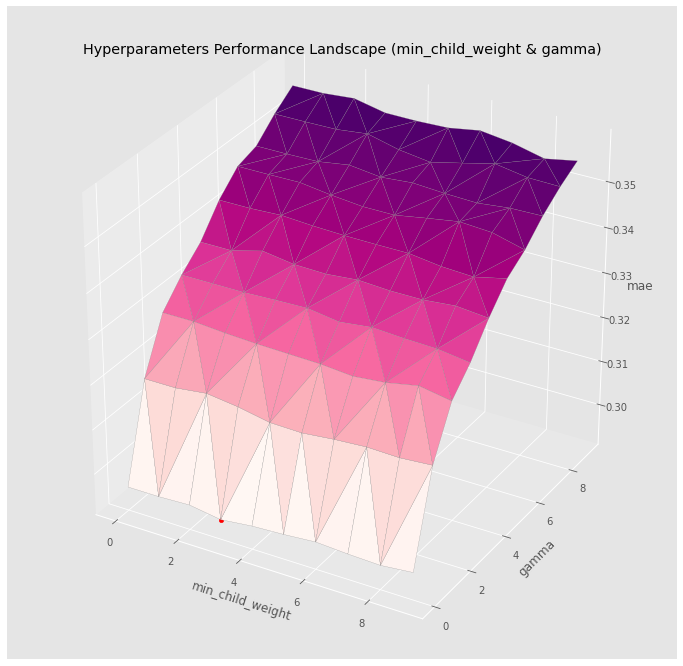

In [43]:
Trisurf("min_child_weight", "gamma", x3, y3, z3, min_mae3, best_params3)

In [44]:
param_dict["min_child_weight"] = best_params3[0]
param_dict["gamma"]= best_params3[1]

The performance landscape of these two partition-associated hyperparameters, `min_child_weight` and `gamma`, did not demonstrat multiple dips and bumps. The relative consistency of in the shape of the performance landscape appears to indicate a model stability within the vicinity of the best values of these two hyperparameters.

### d) The 4th pair: `reg_alpha` and `reg_lambda`

At last, we will conduct the following pair-wise hyperparameter tuning over the following two ***regularization hyperparameters***.


> lambda [default=1, alias: reg_lambda]: L2 regularization term on weights. Increasing this value will make model more conservative.

> alpha [default=0, alias: reg_alpha]: L1 regularization term on weights. Increasing this value will make model more conservative.



In [45]:
pair_wise_gridsearch_params4 = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
    for reg_lambda in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
]
# print(gridsearch_params)

In [46]:
 x4, y4, z4, min_mae4, best_params4, cpu_performance_time, wt_performance_time = pair_wise_gridsearch_CV('reg_alpha', 'reg_lambda', pair_wise_gridsearch_params4)

CV with reg_alpha=0, reg_lambda=0
	MAE 0.29730782049301363 for 233 rounds
CV with reg_alpha=0, reg_lambda=0.01
	MAE 0.29697278886455897 for 253 rounds
CV with reg_alpha=0, reg_lambda=0.1
	MAE 0.2981971877730555 for 187 rounds
CV with reg_alpha=0, reg_lambda=1
	MAE 0.29649830207286415 for 259 rounds
CV with reg_alpha=0, reg_lambda=2
	MAE 0.2938102416135852 for 254 rounds
CV with reg_alpha=0, reg_lambda=3
	MAE 0.29343189652768525 for 320 rounds
CV with reg_alpha=0, reg_lambda=4
	MAE 0.2944136683927796 for 253 rounds
CV with reg_alpha=0, reg_lambda=8
	MAE 0.2949484324462962 for 254 rounds
CV with reg_alpha=0, reg_lambda=10
	MAE 0.29344160282161347 for 322 rounds
CV with reg_alpha=0, reg_lambda=12
	MAE 0.29378607125822886 for 320 rounds
CV with reg_alpha=0, reg_lambda=14
	MAE 0.2947993961569567 for 258 rounds
CV with reg_alpha=0.01, reg_lambda=0
	MAE 0.2982692250216654 for 188 rounds
CV with reg_alpha=0.01, reg_lambda=0.01
	MAE 0.29566562375010447 for 319 rounds
CV with reg_alpha=0.01, reg

In [47]:
print("Best params: {:.4f}, {:.4f}, MAE: {}".format(best_params4[0], best_params4[1], min_mae4))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 0.1000, 8.0000, MAE: 0.2923583947526392
Wall-time base performance time: 976.4927 seconds
CPU base performance time: 980.0792 seconds


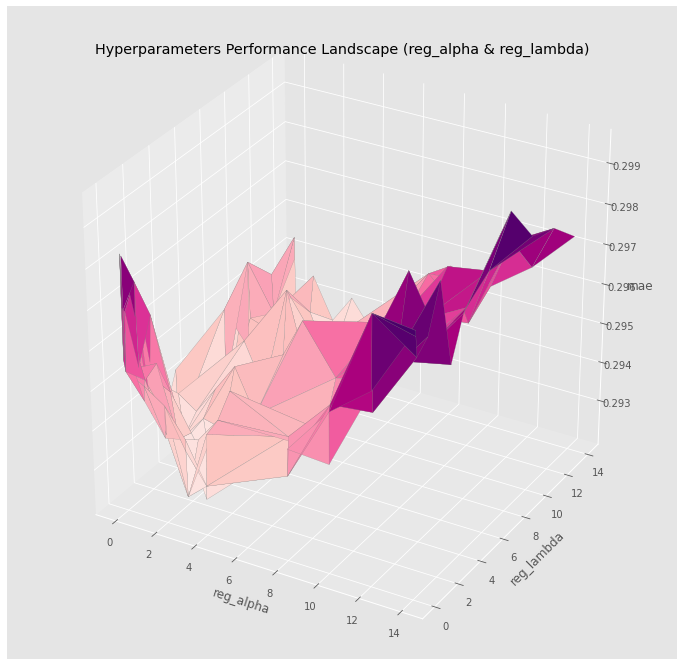

In [48]:
Trisurf("reg_alpha", "reg_lambda", x4, y4, z4, min_mae4, best_params4)

### Multiple Local Minima and Model Instability:

Unlike 3 other earlier performance landscapes, the pair-wise performance landscape of `reg_alpha` and `reg_lambda` rendered "multiple local minima" as you see in the chart. It demonstrated a rugged performance landscape with various dips and bumps. It is an evidence that the performance of the model during the tuning was very sensitive to small changes in the values of these 2 regularization hyperparameters: `reg_alpha` and `reg_lambda`. 

In other words, a slight change in their values can greatly influence the result of their performance. This might well translate into ***a model instability*** within the vicinity of the best values of these two hyperparameters, when we pass a new type of dataset into the tuned model in the deployment domain.

This needs to be closely studied before making a final conclusion.

For now, we update the parameter dictionary with the current best values for `reg_alpha` and `reg_lambda` and calculate the performance of the tuned model on the test dataset.

In [49]:
param_dict["reg_alpha"] = best_params4[0]
param_dict["reg_lambda"]= best_params4[1]

In [50]:
print("Parameters after the Pair Wise Tuning:", param_dict)

Parameters after the Pair Wise Tuning: {'objective': 'reg:squarederror', 'max_depth': 7, 'subsample': 0.9, 'eta': 0.1, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 8, 'eval_metric': 'mae', 'gpu_id': 0, 'tree_method': 'gpu_hist'}


### e) Post 1st Pair-Wise Tuning Test Result

In [51]:
pw_model_1, pw_evals_result_1=bias_variance_performance(param_dict)


[0]	Train-mae:1.41148	Test-mae:1.43711
[1]	Train-mae:1.27641	Test-mae:1.29961
[2]	Train-mae:1.15571	Test-mae:1.17964
[3]	Train-mae:1.05030	Test-mae:1.07459
[4]	Train-mae:0.95576	Test-mae:0.97865
[5]	Train-mae:0.87158	Test-mae:0.89381
[6]	Train-mae:0.79644	Test-mae:0.81891
[7]	Train-mae:0.73224	Test-mae:0.75521
[8]	Train-mae:0.67443	Test-mae:0.69824
[9]	Train-mae:0.62417	Test-mae:0.64866
[10]	Train-mae:0.58036	Test-mae:0.60546
[11]	Train-mae:0.54343	Test-mae:0.56936
[12]	Train-mae:0.51035	Test-mae:0.53770
[13]	Train-mae:0.48297	Test-mae:0.51130
[14]	Train-mae:0.45987	Test-mae:0.48855
[15]	Train-mae:0.43651	Test-mae:0.46557
[16]	Train-mae:0.41806	Test-mae:0.44779
[17]	Train-mae:0.40131	Test-mae:0.43228
[18]	Train-mae:0.39014	Test-mae:0.42219
[19]	Train-mae:0.37997	Test-mae:0.41293
[20]	Train-mae:0.36701	Test-mae:0.40071
[21]	Train-mae:0.35931	Test-mae:0.39384
[22]	Train-mae:0.35083	Test-mae:0.38663
[23]	Train-mae:0.34364	Test-mae:0.38023
[24]	Train-mae:0.33867	Test-mae:0.37594
[25]	Train

In [52]:
pw_best_performance_1 = pw_model_1.best_score

In [53]:
print("Best MAE after the Pair-Wise Tuning: {:.4f} with {} rounds".format(
                 pw_model_1.best_score,
                 pw_model_1.best_iteration+1))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))

Best MAE after the Pair-Wise Tuning: 0.2903 with 315 rounds
Wall-time base performance time: 976.4927 seconds
CPU base performance time: 980.0792 seconds


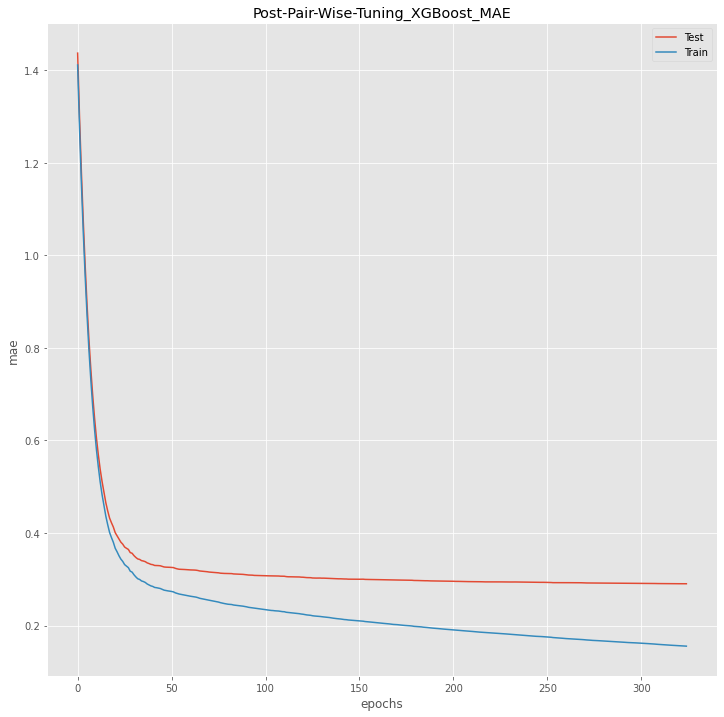

(None, 'Post-Pair-Wise-Tuning_XGBoost_MAE')

In [54]:
epoch_MAE_visual(evals_result=pw_evals_result_1, title="Post-Pair-Wise-Tuning")

The result yielded a slight improvement in the test performance. 
 

## 07 Multiple Local Minima and Model Instability:
### Highly Sensitive Model Peformance regarding `reg_alpha` and `reg_lambda`

Repeatedly, the tuning process of these 2 regularization parameters, `reg_alpha` and `reg_lambda`, generated a rugged performance landscape with various dips and bumps, thus "multiple local minima". It is an evidence that the performance during the tuning process was very sensitive to changes in the values of these 2 regularization hyperparameters. A slight change in their values can dramatically influence the result of their performance, the value of the objective function (loss function).

A relevant question/concern is whether the sensitivity of the model performance within the vicinity of the best values of the tuned hyperparameter pair can cause a material model instability (variance), when we pass a new dataset into the tuned model.


We can at least make a closer observation on the current performance landscape and assess the sensitivity of the model to small changes in the values of the hyperparameter pair.

First, we can rank the top 10 tuning results according to their performance.

Second, based on the observation on the top 10 tuning results, we can slice the performance landscape to have a closer look at its consistency, or the performance stability. 　


### a) A closer look at Multiple Local Minima: Check the top 10 lowest `mae`

By ranking `mae`, or the k-fold cross-validation results of the pair-wise hyperparameter tuning, we might get some insights about ***mltiple local minima***.
    
    


In [55]:
df = pd.DataFrame(list(zip(x4, y4, z4)),
               columns =['reg_alpha', 'reg_lambda', 'mae'])

In [56]:
df.shape

(121, 3)

In [57]:
sorted_df = df.sort_values(by=['mae'], ascending=True)
sorted_df.head(10)

,reg_alpha,reg_lambda,mae
29,0.10,8.00,0.292358
57,3.00,0.10,0.292648
59,3.00,2.00,0.292699
32,0.10,14.00,0.292707
66,4.00,0.00,0.292770
17,0.01,4.00,0.292814
64,3.00,12.00,0.292936
18,0.01,8.00,0.292966
67,4.00,0.01,0.293104
38,1.00,3.00,0.293107


The sorted dataframe ranks the top 10 datapoints in an ascending order of the values of the evaluation metrics of `'mae'`.

Now when we see `reg_alpha`, the top 10 tuning result datapoints are distributed within (0.1, 4.0) along `reg_alpha`

For `reg_lambda`, its top 10 ranking values scattered across a wide range (0.00 to 12).

In order to gain a better insight, we can slice the 3D performance landscape at the following sections:
- `reg_alpha`= 0.1
- `reg_alpha`= 3.0
- `reg_alpha`= 0.01
- `reg_lambda`= 8.0

All those values appear in the top 10 performance datapoints list. 

### Slicing the Performance Landscape to see closer Local Minima

The next cell defines a 2D Visualization utility function.

The purpose of this visualization is to slice the performance landscape into 2D grid at a given value of either  `reg_alpha` or `reg_lambda`.



In [58]:
# 2D Visualization Utility for slicing the 3D Tri-Surface Performance Landscape
def visualization_2D(df_slice, xname, yname, graph_name):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    
    x_var = df_slice[[xname]]
    y_var = df_slice[[yname]]
    
    ax.plot(x_var, y_var)
    
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)

    # Write the Title
    ax.set_title(str(graph_name))
    
    # Download the figure as jpeg file.
    fig.savefig(graph_name + '.jpg')

First, we slice the performance landscape @ `reg_alpha`=0.1.

In [59]:
df_slice_a=df.loc[(df['reg_alpha']==0.1)]
df_slice_a

,reg_alpha,reg_lambda,mae
22,0.1,0.00,0.296150
23,0.1,0.01,0.295401
24,0.1,0.10,0.296862
25,0.1,1.00,0.295246
26,0.1,2.00,0.296310
27,0.1,3.00,0.294243
28,0.1,4.00,0.293813
29,0.1,8.00,0.292358
30,0.1,10.00,0.294250
31,0.1,12.00,0.293885


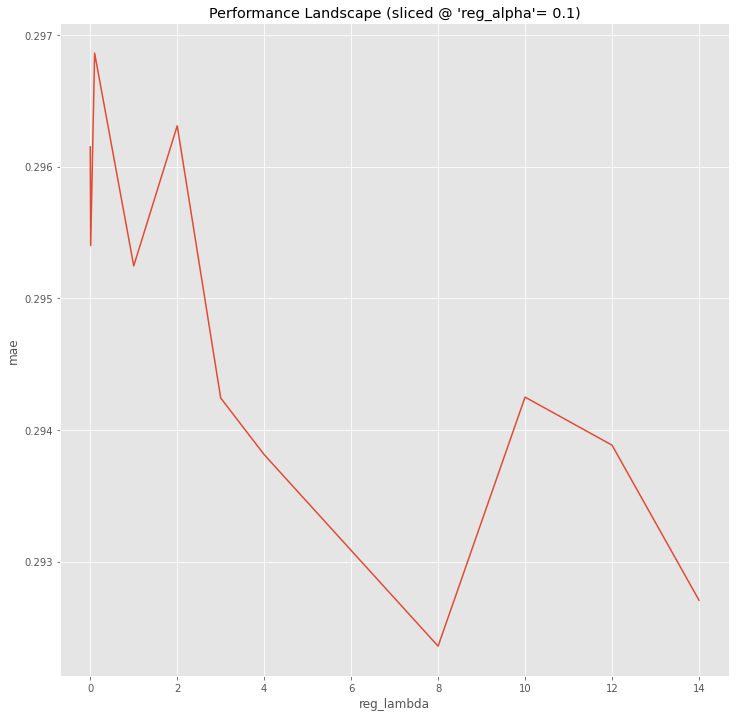

In [60]:
df_slice=df_slice_a
xname = 'reg_lambda'
yname ='mae'
graph_name ="Performance Landscape (sliced @ 'reg_alpha'= 0.1)"
visualization_2D(df_slice, xname, yname, graph_name)


The chart above captures the performance curve sliced at `reg_alpha`= 0.1.

Although there are 3 local minima in the sliced chart, it confirms that <font color=blue>***(`reg_alpha`=0.1,`reg_lambda`=8.0)***</font> is <font color="purple">***the lowest value of `mae`***</font> captured on the search grid.



Next, let's slice the performance landscape @ `reg_alpha`=3.0 to see the shape of its curve.

In [61]:
df_slice_b=df.loc[(df['reg_alpha']==3.0)]
df_slice_b

,reg_alpha,reg_lambda,mae
55,3.0,0.00,0.294128
56,3.0,0.01,0.293835
57,3.0,0.10,0.292648
58,3.0,1.00,0.293857
59,3.0,2.00,0.292699
60,3.0,3.00,0.293599
61,3.0,4.00,0.294931
62,3.0,8.00,0.294218
63,3.0,10.00,0.293330
64,3.0,12.00,0.292936


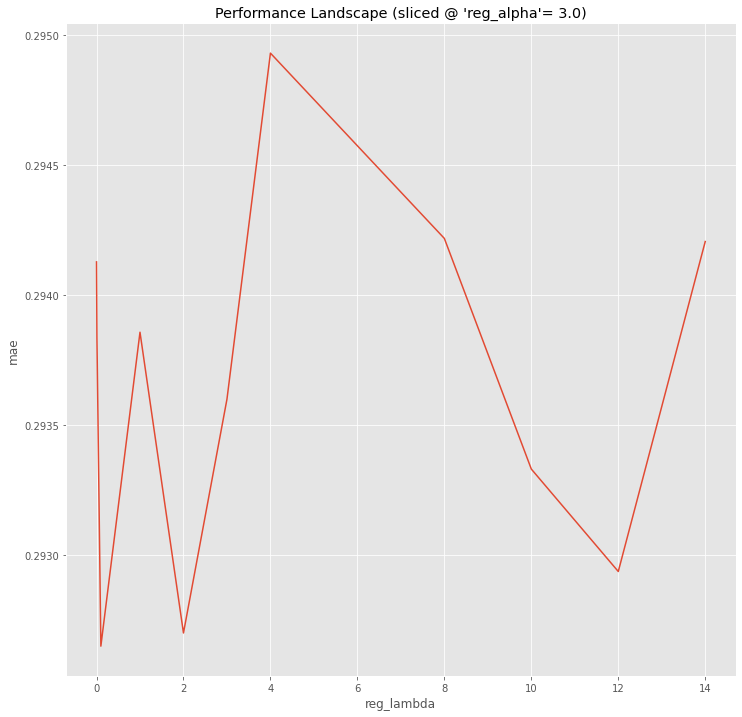

In [62]:
df_slice=df_slice_b
xname = 'reg_lambda'
yname ='mae'
graph_name ="Performance Landscape (sliced @ 'reg_alpha'= 3.0)"
visualization_2D(df_slice, xname, yname, graph_name)


The slice of the performance landscape at (`reg_alpha`=3.0) identifies an acute abyss formed between (`reg_lambda`=0.01) and (`reg_lambda`=1.0). The intense asperity in the shape of the abyss was captured by the finer search grid setting along (`reg_lambda`=0.01), (`reg_lambda`=0.1), and (`reg_lambda`=1) than any other part of the search grid. In other words, if we missed the single datapoint of (`reg_lambda`=0.1) in our search-grid, we would have failed to capture the presence of the local minimum between (`reg_lambda`=0.01) and (`reg_lambda`=1.0).

This is a general pitfall of the grid-search. What the performance landscape captured are only the performance results projected on the selected search-grid. Call them "on-the-search-grid performance". We have no information whatsoever regarding the performance of any datapoint off the search grid. Call them "off-the-search-grid performance". 

In addition, the visualization makes the situation worse, by interpolating (triangulation interpolation) the on-the-search-grid performances to speculate those invisible performances off the-search-grid. The smoothed out image over off-the-search-grid intervals is only an artefact, but not the fact at all. And the artefact might be accounting for an illusion of knowledge. In other words, we might be deceiving ourselves by blind-holding our vision with the artefact of the smoothed-out visualization. 

A much finer granularity in the search-grid setting might reveal a much more intense asperity of the rugged performance landscape. That is to say, we might discover more dips and bumps by a more granular search-grid setting. It might uncover the presence of many other hidden local minima, which are invisible in the current performance landscape. 

Furthermore, the ground-truth global minimum might well be present off the current search-grid and located at far distance from the current best minimum identified by the current search-grid setting.

Simply put, the current performance landscape might be not only capturing a partial picture of its asperity, but also deceiving our vision. 



In [63]:
df_slice_c=df.loc[(df['reg_alpha']==0.01)]
df_slice_c

,reg_alpha,reg_lambda,mae
11,0.01,0.00,0.298269
12,0.01,0.01,0.295666
13,0.01,0.10,0.296882
14,0.01,1.00,0.297354
15,0.01,2.00,0.295114
16,0.01,3.00,0.293495
17,0.01,4.00,0.292814
18,0.01,8.00,0.292966
19,0.01,10.00,0.295689
20,0.01,12.00,0.294888


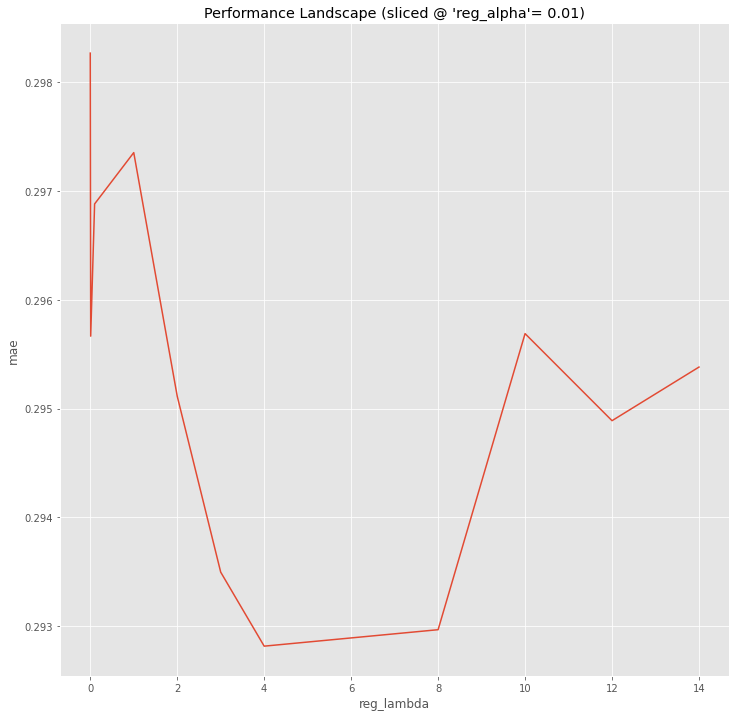

In [64]:
df_slice=df_slice_c
xname = 'reg_lambda'
yname ='mae'
graph_name ="Performance Landscape (sliced @ 'reg_alpha'= 0.01)"
visualization_2D(df_slice, xname, yname, graph_name)


In [67]:
df_slice_e=df.loc[(df['reg_lambda']==8.0)]
df_slice_e

,reg_alpha,reg_lambda,mae
7,0.00,8.0,0.294948
18,0.01,8.0,0.292966
29,0.10,8.0,0.292358
40,1.00,8.0,0.294282
51,2.00,8.0,0.293173
62,3.00,8.0,0.294218
73,4.00,8.0,0.295235
84,8.00,8.0,0.295765
95,10.00,8.0,0.296138
106,12.00,8.0,0.296704


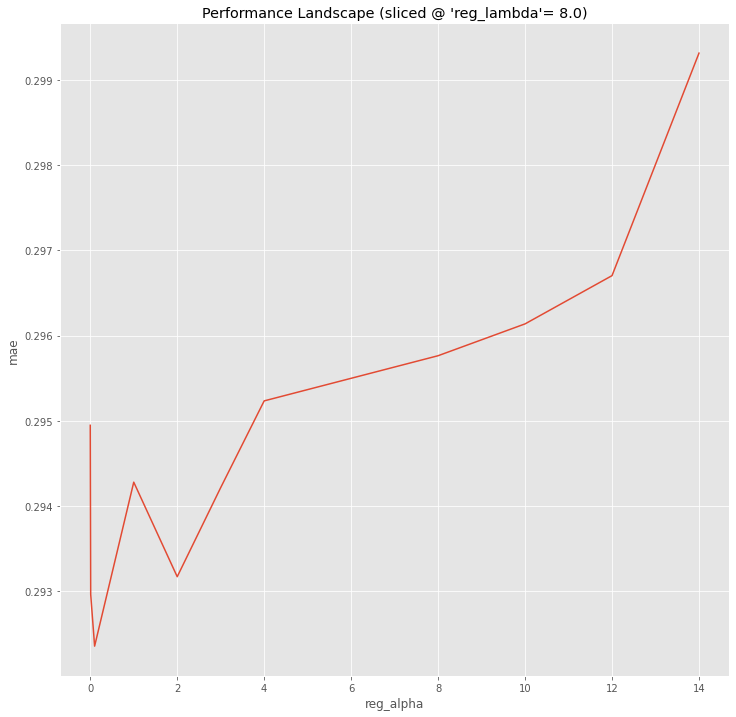

In [68]:
df_slice=df_slice_e
xname = 'reg_alpha'
yname ='mae'
graph_name ="Performance Landscape (sliced @ 'reg_lambda'= 8.0)"
visualization_2D(df_slice, xname, yname, graph_name)


## Tentative Observations on Multiple Local Minima


We can make the following observations from the sorted dataframe and the visualization of the performance landscape:

The tuning of the hyperprameter pair, (`reg_alpha`, `reg_lambda`), demonstrated a rugged performance landscape with multiple dips and bumps and multiple local minima. It indicates a slient sensitivity of the model during the tuning process to small changes in the values of these hyperparameters. Although the grid search tuning identified (`reg_alpha`=0.1, `reg_lambda`=8.0) as the current lowest `'mae'` captured on the current search grid, there is no guarantee that this is the ground-truth global minimum, or even its robust proxy, for the following 3 reasons at least.

1. Given the extraordinary sensitivity of the model, the granularity of the current search-grid might not be fine enough to capture the ground-truth global minimum. It might be present off the current search-grid and positioned at a far distant location from the current best minimum identified on the current search-grid setting. This illustrates a general inherent limitation of the grid search, its partiality.

2. A joint optimization together with the other 6 hyperparameters might reveal other interactions among hyperparameters that were not captured by the pair-wise optimization. And it might yield a totally different performance landscape.
    
All these given defects of the current tuning might cause an instability of the tuned model, when we pass a new type of dataset.

Now, here are other slices that I made, the readers can view the process and the results, if interested.

In [65]:
df_slice_d=df.loc[(df['reg_lambda']==14.0)]
df_slice_d

,reg_alpha,reg_lambda,mae
10,0.00,14.0,0.294799
21,0.01,14.0,0.295381
32,0.10,14.0,0.292707
43,1.00,14.0,0.294508
54,2.00,14.0,0.293476
65,3.00,14.0,0.294206
76,4.00,14.0,0.293513
87,8.00,14.0,0.295737
98,10.00,14.0,0.295487
109,12.00,14.0,0.296252


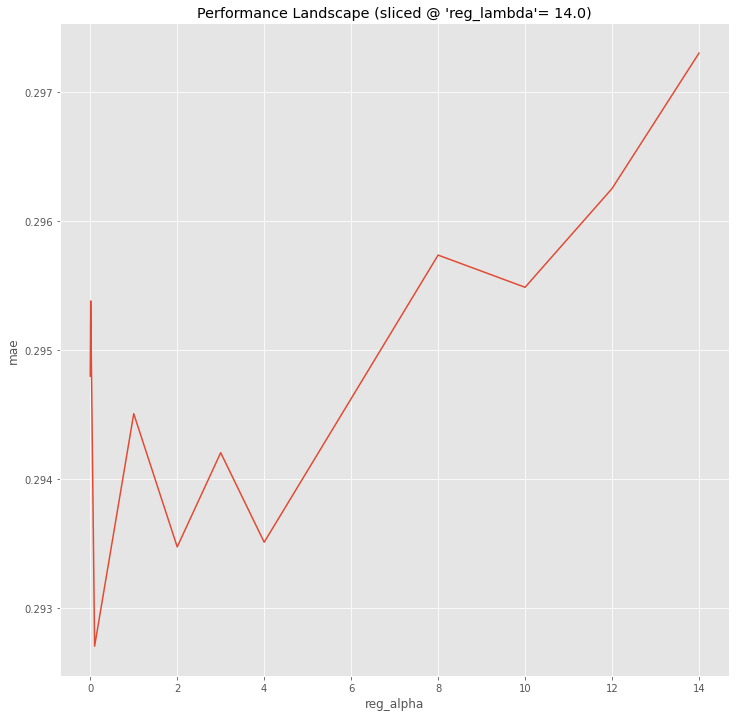

In [66]:
df_slice=df_slice_d
xname = 'reg_alpha'
yname ='mae'
graph_name ="Performance Landscape (sliced @ 'reg_lambda'= 14.0)"
visualization_2D(df_slice, xname, yname, graph_name)


Last, let's slice the performance landscape @ `reg_lambda`=8.0.

By doing so, we can also check the 3rd best pair of (`reg_alpha`=0.1,`reg_lambda`=8.0)

In [67]:
df_slice_e=df.loc[(df['reg_lambda']==8.0)]
df_slice_e

,reg_alpha,reg_lambda,mae
7,0.00,8.0,0.294948
18,0.01,8.0,0.292966
29,0.10,8.0,0.292358
40,1.00,8.0,0.294282
51,2.00,8.0,0.293173
62,3.00,8.0,0.294218
73,4.00,8.0,0.295235
84,8.00,8.0,0.295765
95,10.00,8.0,0.296138
106,12.00,8.0,0.296704


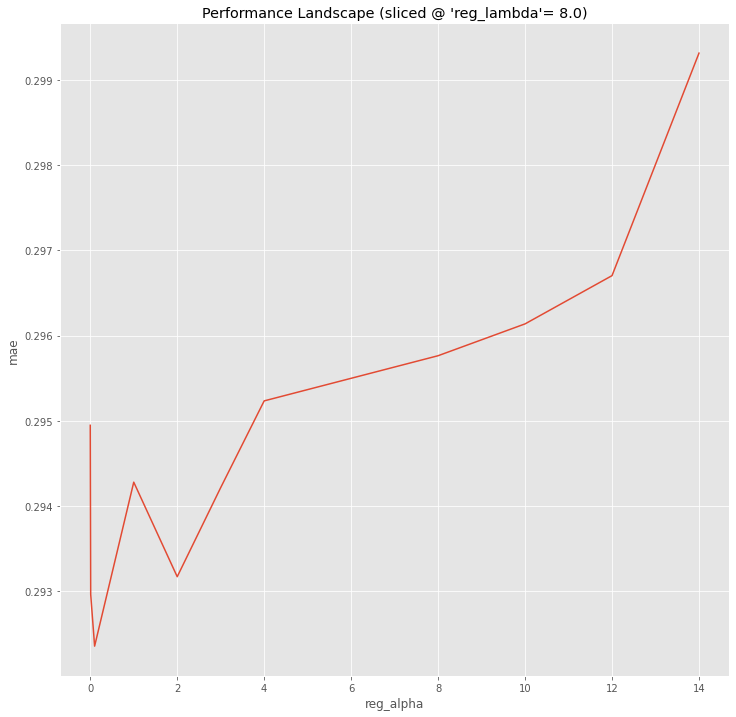

In [68]:
df_slice=df_slice_e
xname = 'reg_alpha'
yname ='mae'
graph_name ="Performance Landscape (sliced @ 'reg_lambda'= 8.0)"
visualization_2D(df_slice, xname, yname, graph_name)


## 08 More Granular Search Grid for `reg_alpha` and `reg_lambda`


From the observation of the last pair-wise tuning over the regularization hyperparamters, `reg_alpha` and `reg_lambda`, we attained an insight that the first search-grid might not be granular enough to capture the global minimum or at least its robust proxy.

A relevant question arises, how much the granularity of the search-grid would need to be refined to identify the ground-truth global minimum. The answer does not seem self-evident. If it were epistemologically impossible for us to define the right granularity of the search-grid to identify the ground-truth global minimum, at least, a more granular search grid might yield a better result.

In this view, we can set a more granular search-grid to run the second round of the pair-wise tuning over the hyperparameter pair of (`reg_alpha`, `reg_lambda`). 
    
Following the spirit of ***Bayesian Optimization***, we can narrow our focus in the area of the current top 10 performance results to enhance the granularity of our next grid search. 

As an example, based on the current result, we can set the following search-grid below for the 2nd round.

1. `reg_alpha`: because the top 10 performances were observed within the range of (0, 4.0), we can set the next search grid as follows:
```Python
reg_alpha in [0, 1e-2, 2e-2, 3e-2, 0.1, 0.5, 1, 1.5, 1.8, 1.9, 2, 2.1, 2.2, 2.5, 3, 3.5, 4]
```
2. `reg_lambda`: because the top 10 performances were scattered across the range of (0, 12.0), we can set the next search grid as follows:
```Python
reg_lambda in [0, 1e-2, 2e-2, 3e-2, 0.1, 0.5, 1, 1.5, 1.8, 1.9, 2, 2.1, 2.2, 2.5, 3, 4, 5, 6, 
                       7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]
```


In [69]:
pair_wise_gridsearch_params4 = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 1e-2, 2e-2, 3e-2, 0.1, 0.5, 1, 1.5, 1.8, 1.9, 2, 2.1, 2.2, 2.5, 3, 3.5, 4]
    for reg_lambda in [0, 1e-2, 2e-2, 3e-2, 0.1, 0.5, 1, 1.5, 1.8, 1.9, 2, 2.1, 2.2, 2.5, 3, 4, 5, 6, 
                       7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5]
]

In [70]:
 x4a, y4a, z4a, min_mae4a, best_params4a, cpu_performance_time, wt_performance_time = pair_wise_gridsearch_CV('reg_alpha', 'reg_lambda', pair_wise_gridsearch_params4)

CV with reg_alpha=0, reg_lambda=0
	MAE 0.29730782049301363 for 233 rounds
CV with reg_alpha=0, reg_lambda=0.01
	MAE 0.29697278886455897 for 253 rounds
CV with reg_alpha=0, reg_lambda=0.02
	MAE 0.2978370727706479 for 252 rounds
CV with reg_alpha=0, reg_lambda=0.03
	MAE 0.2976280502859474 for 255 rounds
CV with reg_alpha=0, reg_lambda=0.1
	MAE 0.2981971877730555 for 187 rounds
CV with reg_alpha=0, reg_lambda=0.5
	MAE 0.2966269276054331 for 253 rounds
CV with reg_alpha=0, reg_lambda=1
	MAE 0.29649830207286415 for 259 rounds
CV with reg_alpha=0, reg_lambda=1.5
	MAE 0.29599567062825505 for 254 rounds
CV with reg_alpha=0, reg_lambda=1.8
	MAE 0.2953472162613727 for 259 rounds
CV with reg_alpha=0, reg_lambda=1.9
	MAE 0.298393965941837 for 188 rounds
CV with reg_alpha=0, reg_lambda=2
	MAE 0.2938102416135852 for 254 rounds
CV with reg_alpha=0, reg_lambda=2.1
	MAE 0.29468142753154114 for 258 rounds
CV with reg_alpha=0, reg_lambda=2.2
	MAE 0.29554764779347165 for 253 rounds
CV with reg_alpha=0, re

In [71]:
print("Best params: {:.4f}, {:.4f}, MAE: {}".format(best_params4a[0], best_params4a[1], min_mae4a))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))


Best params: 0.5000, 13.5000, MAE: 0.29122008437950175
Wall-time base performance time: 4634.7304 seconds
CPU base performance time: 4652.7035 seconds


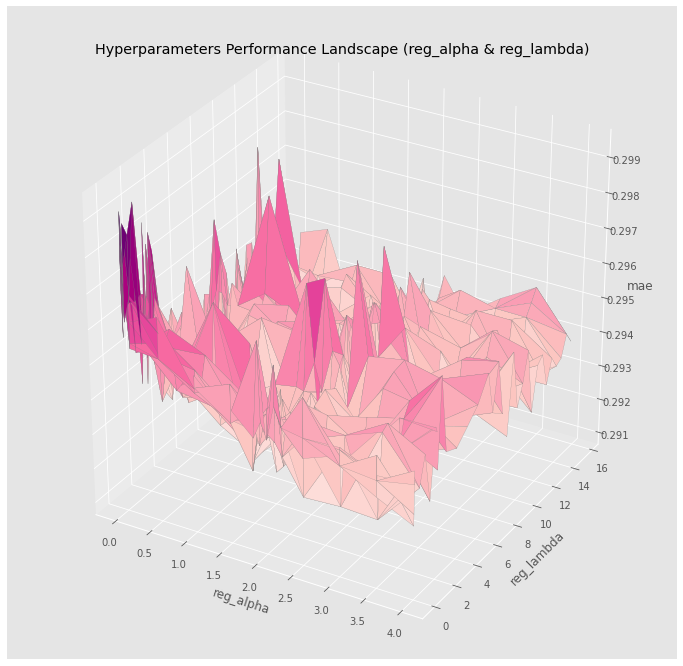

In [72]:
Trisurf("reg_alpha", "reg_lambda", x4a, y4a, z4a, min_mae4a, best_params4a)

In [73]:
param_dict["reg_alpha"] = best_params4a[0]
param_dict["reg_lambda"]= best_params4a[1]

In [74]:
print("Parameters after the Pair Wise Tuning:", param_dict)

Parameters after the Pair Wise Tuning: {'objective': 'reg:squarederror', 'max_depth': 7, 'subsample': 0.9, 'eta': 0.1, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 13.5, 'eval_metric': 'mae', 'gpu_id': 0, 'tree_method': 'gpu_hist'}


In [75]:
df_a = pd.DataFrame(list(zip(x4a, y4a, z4a)),
               columns =['reg_alpha', 'reg_lambda', 'mae'])

In [76]:
df_a.shape

(612, 3)

In [77]:
sorted_df_a = df_a.sort_values(by=['mae'], ascending=True)
sorted_df_a.head(10)

,reg_alpha,reg_lambda,mae
211,0.50,13.5,0.291220
143,0.03,15.5,0.291249
171,0.10,11.5,0.291450
105,0.02,14.5,0.291455
59,0.01,9.5,0.291627
212,0.50,14.0,0.291715
358,1.90,15.0,0.291734
355,1.90,13.5,0.291803
131,0.03,9.5,0.291805
173,0.10,12.5,0.291849


### a) Analysis of the 2nd round tuning of `reg_alpha` & `reg_lambda`

Cut a long story short, the second pair-wise tuning just confirmed our concern as real: a more granular grid search could discover a better performance datapoint. 

The 2nd round tuning yielded a much more rugged performance landscape with more dips and bumps. Moreover, the top 10 performance list identifies its best result at a datapoint (`reg_alpha`=0.5, `reg_lambda`=13.5) far from the best result of the 1st round tuning (`reg_alpha`=0.1, `reg_lambda`=8.0).

These results justify our concern that the 1st performance landscape might have failed to capture a robust proxy of the ground-truth global minimum. 

The reason why we performed the more granular tuning was based on the assumption that a more granular search grid might discover hidden datapoints with better performance results.

And so far, the 2nd pair-wise tuning yielded a better performance and confirmed our concern. Remember that ***k-fold cross validation*** uses only the train dataset. Next, we need to further scrutinize this question using the test dataset to assess the situation from the perspective of "bias-variance tradeoff". 

For this purpose, we need to run the tuned model over the test dataset in the next section.




### b) Post 2nd Pair-Wise Tuning Test Result

Here we can run the tuned model over the test dataset.

In [81]:
pw_model_2, pw_evals_result_2=bias_variance_performance(param_dict)


[0]	Train-mae:1.41253	Test-mae:1.43806
[1]	Train-mae:1.27819	Test-mae:1.30116
[2]	Train-mae:1.15895	Test-mae:1.18243
[3]	Train-mae:1.05289	Test-mae:1.07732
[4]	Train-mae:0.95870	Test-mae:0.98160
[5]	Train-mae:0.87510	Test-mae:0.89761
[6]	Train-mae:0.80348	Test-mae:0.82602
[7]	Train-mae:0.73973	Test-mae:0.76277
[8]	Train-mae:0.68203	Test-mae:0.70556
[9]	Train-mae:0.63271	Test-mae:0.65693
[10]	Train-mae:0.58927	Test-mae:0.61407
[11]	Train-mae:0.55183	Test-mae:0.57707
[12]	Train-mae:0.51971	Test-mae:0.54562
[13]	Train-mae:0.49218	Test-mae:0.51883
[14]	Train-mae:0.46915	Test-mae:0.49604
[15]	Train-mae:0.44533	Test-mae:0.47267
[16]	Train-mae:0.42724	Test-mae:0.45447
[17]	Train-mae:0.41092	Test-mae:0.43889
[18]	Train-mae:0.39961	Test-mae:0.42865
[19]	Train-mae:0.38941	Test-mae:0.41933
[20]	Train-mae:0.37718	Test-mae:0.40793
[21]	Train-mae:0.36930	Test-mae:0.40101
[22]	Train-mae:0.35967	Test-mae:0.39193
[23]	Train-mae:0.35124	Test-mae:0.38445
[24]	Train-mae:0.34620	Test-mae:0.38025
[25]	Train

In [82]:
pw_best_performance_2 = pw_model_2.best_score

In [83]:
print("Best MAE after the Pair-Wise Tuning: {:.4f} with {} rounds".format(
                 pw_model_2.best_score,
                 pw_model_2.best_iteration+1))
print("Wall-time base performance time: {:.4f} seconds".format(wt_performance_time))
print("CPU base performance time: {:.4f} seconds".format(cpu_performance_time))

Best MAE after the Pair-Wise Tuning: 0.2922 with 319 rounds
Wall-time base performance time: 4634.7304 seconds
CPU base performance time: 4652.7035 seconds


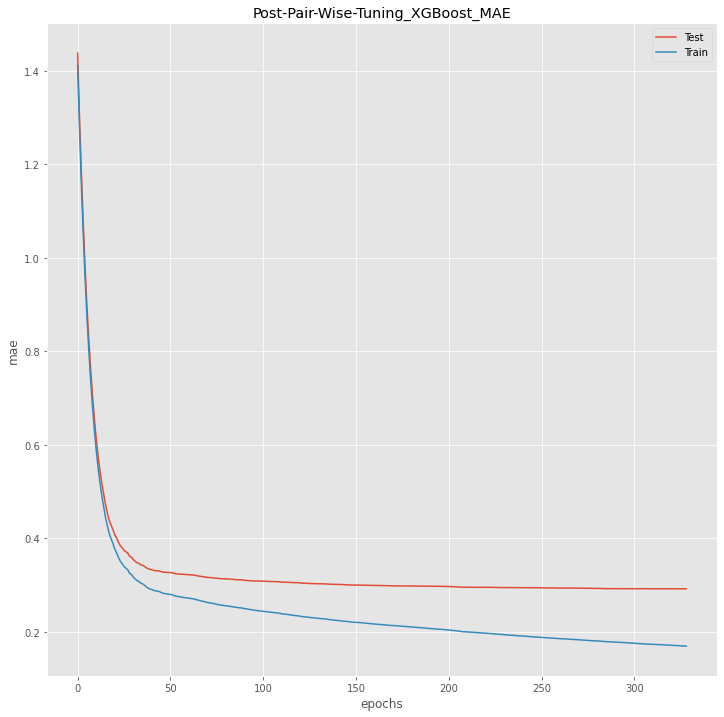

(None, 'Post-Pair-Wise-Tuning_XGBoost_MAE')

In [84]:
epoch_MAE_visual(evals_result=pw_evals_result_2, title="Post-Pair-Wise-Tuning")

### c) Overall Assessment

Now, let's make a summary table to compare the performance for the cross validation (Test Dataset) and the test for the following three phases.
1. Pre-Tuning Phase
2. Post-1st-Pair-Wise-Tuning Phase
3. Post-2nd-Pair-Wise-Tuning Phase

In [85]:
data_2 = {"Tuning Phase":["Pre-Tuning", "Post-1st-Pair-Wise-Tuning", "Post-2nd-Pair-Wise-Tuning"], 
          "reg_alpha": [format(0.1, '.2f'), format(best_params4[0], '.2f'), format(best_params4a[0], '.2f')], 
          "reg_lambda": [format(1, '.2f'), format(best_params4[1], '.2f'), format(best_params4a[1], '.2f')],
          "Tuning (Validation MAE)": ["None", format(min_mae4, '.5f'), format(min_mae4a, '.5f')], 
          'Test Performance (MAE)': [format(pre_best_performance, '.5f'), format(pw_best_performance_1, '.5f'), format(pw_best_performance_2, '.5f')]}
Test_Performance=pd.DataFrame(data_2)
Test_Performance

,Tuning Phase,reg_alpha,reg_lambda,Tuning (Validation MAE),Test Performance (MAE)
0,Pre-Tuning,0.10,1.00,None,0.31031
1,Post-1st-Pair-Wise-Tuning,0.10,8.00,0.29236,0.29034
2,Post-2nd-Pair-Wise-Tuning,0.50,13.50,0.29122,0.29225



The table summarizes the comparison between the validation performance and the test performance over three stages: the pre-tuning, the post-1st-tuning, the post-2nd-tuning. 


While the validation performance improved from the 1st tuning stage to the 2nd tuning stage, the test performance deteriorated after the 1st tuning.

This observation that the better validation performance of the second round tuning did not translate into a better test performance might appear counter-intuitive. Instead, it rather accounted for a higher ***variance*** of the model when we passed the test dataset into the tuned model. This counter-intuitive observation is just another example of a typical problem of "***variance-bias trade-off***", the problem of ***over-fitting***.

The overall objective of the tuning during the model development is the generalization of the model performance: in other words, to pursue the model stability in the deployment domain. In this context, we need to address ***'variance-bias trade-off'*** in the selection of the tuned model. Above all, we are better off selecting the result of the 1st tuning, rather than the 2nd tuning.



###   d) Plot the Feature Importance </font>

Based on the hyperparameters tuned in the 1st round tuning, we can plot ***the Feature Importance*** of the tuned model.

Source 1: https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=variable%20importance#xgboost.plot_importance

Source 2: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [87]:
from xgboost import plot_importance

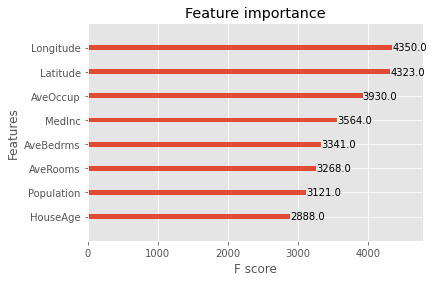

In [88]:
plot_importance(pw_model_1)
pyplot.show()

# Closing Remark:


The project used the grid search for conducting the hyperparameter tuning and the triangulation interpolation for rendering the 3D visualization of the performance landscape over all the hyperparameter datapoints on the search grid. Like any other methods, these methods have their inherent limitations embedded in their design. And the result of the particular pair-wise tuning of `reg_alpha` and `reg_lambda`, demonstrating "***multiple local minima***" which is a symptom of a highly sensitive/volatile performance, exposed the risk of those design limitations. 

Here is an overview of their limitations.

**Limitation 1) Blindspot of the Grid-Search:**
- The search grid is set as a collection of selected discrete hyperparameter datapoints. Call them "on-the-search-grid datapoints". The grid-search only renders the performance results on those discrete hyperparameter datapoints in the selected search grid. Call them "on-the-search-grid performance". 
- Tuning does not tell us what is going on inbetween any two "on-the-search-grid datapoints" next to each other. We have no knowledge whatsoever regarding the values of the performance (evaluation metric) off the selected search grid. Call them "off-the-search-grid performance". Therefore, the tuning results only give us a partial picture of the underlying performance landscape at best.

**Limitation 2) Illusionary Visualization**
- The 3D visualization projects not only the on-the-search-grid performance, but also the artefact of triangulation interpolation for estimating the off-the-search-grid performance.
- The artefact creates an illusion of knowledge regarding the "off-the-search-grid evaluation metric values".

    
Among 4 pair-wise hyperparameter tunings, the first 3 tunings rendered relatively stable performance landscapes without multiple inconsistent dips and bumps. For these cases, those limitations of the grid search and the smoothened visualization did not appear material issues.
    
Nevertheless, the pair-wise performance landscape of `reg_alpha` and `reg_lambda` demonstrated high volatility/sensitivity of the model performance to small changes in the values of the hyperparameter pair. As its symptom, `***multiple local minima***` were observed in the performance landscape for the hyperparameter pair. 

In a sense, the highly sensitive model performance of `reg_alpha` and `reg_lambda` amplified those limitations and exposed the risk of these 2 methods above. 

If the current search grid captures only a partial image of its sensitivity, the ground-truth performance landscape off the-search-grid might be far more sensitive/volatile and far more rugged with more dips and bumps than it appears on the current search grid. In other words, due to its high sensitivity, the ground-truth "off-the-grid performance" could materially deviate from the artefact of the interpolated estimates projected on the 3D visualization. 
    
Moreover, ***the high sensitivity of performance landscape*** might further cast a risk that ***the ground-truth global minimum*** might be present off-the-search-grid and materially distant from ***on-the-search-grid global minimum***. In this sense, ***multiple local minima***, when compared with 3 other cases with only single local minimum, amplifies the risk of suffering from those inherent limitations of the grid search and the triangulation interpolation technique of the visualization.
    
Nevertheless, when it comes to decision-making for the model selection, from the perspective of "***variance-bias trade-off***", the problem of ***over-fitting***, we selected the 1st round result and rejected the 2nd round result.
    
All that said, whether the first round tuning result is the best solution in an absolute sense remains uncertain and not self-evident. Given the sensitive volatile performance landscape demonstrated by these two regularization hyperparameters, there might be better solutions present off the search-grid used in the 1st round and 2nd round. Above all, we can never know the best solution in an absolute sense, when we use the grid search parameter tuning. Above all, a grid-search can capture only a partial aspect of the performance landscape that are projected only on the search grid. We have no information whatsoever regarding the performance off the search-grid. 
    
In this sense, we do not have the whole picture of the entire performance landscape. In principle, our knowledge is limited to those discrete on-the-search-grid datapoints.

Furthermore, there is another obvious limitation of the selected tuning approach. 

**Limitation 3) Partiality of *pair-wise tuning**
- With only 4 pair-wise tunings, we are not covering all the possible combination pairs (28=8×7/2) for 8 hyperparameters. Behaviors among those missing combinations are not captured by the 4 pair-wise tunings. 
- When all the hyperparameters were tuned together simultaneously at once, the result might display a totally different shape of the performance landscape. In this sense, the global minimum captured by the pair-wise tuning would likely be different from the ground-truth global minimum.

Now, here are relevant questions to ask:
    
Q1) Is it possible for us to reach a robust proxy? The answer to this question could be shaped from the following three perspectives.

If it were epistemologically impossible for us to locate the ground-truth global minimum, at least, a more granular search grid might yield a better result.

* How granular would be enough for the search grid to achieve a robust proxy, if any.
* Or, possibly there might be no such thing like a robust proxy.
* Or more counter-intuitively, the ground-truth global minimum would not matter due to the problem of "bias-variance trade-off", the risk of over-fitting.

Q2) Would "multiple local minima" indicate the model instability of the tuned model? If "multiple local minima" is a symptom of a highly volatile/sensitive performance, it might signal a high risk of the model instability of the tuned model, or the risk of Variance, when we pass a new dataset into the tuned model.


None of these questions seems to have a self-evident answer.

What do you think?

I want to end this analysis with these open questions.